In [1]:
import gym
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

#torch.cuda.set_device(2)

In [2]:
from data import rollout, DataBuffer
from model import Policy, DynamicsModel
from model_utils import train_dynamics_model, cost
from utils import plot_databuffer, plot_trajectories, plot_dynamics_uncertainty, plot_actions, test_episodic_reward

In [3]:
import gym
env = gym.make('Pendulum-v0')

# Some params
N = 30
T = 50  # time steps

# Hyperparam for size of data buffer
tau_length = [10, 100, 1000]

# Hyperparams for dynamics model
list_hidden_neurons = [300]
list_drop_prob = [0.01, 0.005, 0.05, 0.1]
list_lr = [1e-3, 1e-4, 1e-5]
batch_size = 10#T  # but make sure no cutoff in collected data
max_train_step = 5000

# ylim for plotting trajectories (theta)
ylim = [-8, 8]

[2017-10-15 14:08:50,566] Making new env: Pendulum-v0


In [4]:
# Define policies
zero_policy = Policy(env)
for p in zero_policy.parameters():
    p.data.fill_(0.0)

cem_policy = Policy(env)
for p in cem_policy.parameters():
    p.data = torch.FloatTensor([[-6.89395513, -1.03240689]])

random_policy = Policy(env)

uniform_policy = Policy(env)
for p in uniform_policy.parameters():
    #p.data = p.data.uniform_(-7, -4)
    p.data[:, 0] = np.random.uniform(-7, -5)  # first param for theta
    p.data[:, 1] = np.random.uniform(-2, 0)  # second param for thetadot
    
def rand_actions(s):
    return Variable(torch.FloatTensor(env.action_space.sample()))
    
policy_dict = {'zero_policy': zero_policy, 'cem_policy': cem_policy, 'random_policy': random_policy, 'uniform_policy': uniform_policy, 'random_actions': rand_actions}

In [5]:
# Define data buffers for different settings
data_dict = {}

# Mixed data buffer with incremental data, i.e. D1 < D2 < D3 ...
for i, tau_len in enumerate(tau_length[::-1]):  # create data buffer from big to (cover) small
    data = DataBuffer(env)
    data.max_trajectory = 10001  # Temp allow more than 10 trials
    
    if i == 0:  # biggest data buffer, the only one via environment
        # Randomly select set of policies to rollout trajectories
        policy_pool = np.random.choice(list(policy_dict.keys()), size=tau_len, replace=True)
        for policy_name in policy_pool:
            # Rollout one trajectory with selected policy and push to data buffer
            data.push(rollout(env, policy_dict[policy_name], T=T, mode='System'))
    else:  # sample trajectories from super data buffer
        super_data = data_dict[str(tau_length[-i])]
        # sample trajectory indices
        idxs = np.random.choice(tau_length[-i], size=tau_len, replace=False)
        for idx in idxs:
            # Push sampled trajectories from super data buffer to current data buffer
            data.push(super_data.buffer[idx])
    
    # Record data buffer to data dictionary
    data_dict[str(tau_len)] = data

In [6]:
# Define dynamics models and optimizers for di{:.5f}, and fferent settings
dynamics_dict = {}

for hidden_neurons in list_hidden_neurons:
    for drop_prob in list_drop_prob:
        for lr in list_lr:
            dynamics = DynamicsModel(env, hidden_size=hidden_neurons, drop_prob=drop_prob)
            dynamics_optimizer = optim.Adam(dynamics.parameters(), lr=lr)
            
            key_str = 'dynamics_' + str(hidden_neurons) + '_' + str(drop_prob) + '_' + str(lr)
            dynamics_dict[key_str] = [dynamics, dynamics_optimizer]

# Running all settings and save plots

In [ ]:
import os

total_iter = len(tau_length)*len(dynamics_dict.keys())
iter_count = 0

# Training each dynamics with each data buffer and visualize
for dynamics_name, [dynamics, dynamics_optimizer] in dynamics_dict.items():
    for tau_len_name, data in data_dict.items():
        str_dir = './fig/' + dynamics_name + '/' + tau_len_name
        if not os.path.exists(str_dir):
            os.makedirs(str_dir)

        # Save figure of data buffer
        fig_databuffer = plot_databuffer(data, ylim=ylim)
        fig_databuffer.savefig(str_dir + '/databuffer_' + tau_len_name + '.png')

        # Train dynamics model
        train_dynamics_model(dynamics, 
                             dynamics_optimizer, 
                             data, 
                             epochs=max_train_step//(len(data)//batch_size), 
                             batch_size=batch_size)
        
        # Save figure of dynamics uncertainty{:.5f}, and  with recorded actions
        fig_rec_act_unc, fig_rec_act_unc_act = plot_recorded_action_uncertainty(data, 
                                                                                dynamics, 
                                                                                T=T, 
                                                                                N_uncertainty=5, 
                                                                                N_plots=3, 
                                                                                ylim=ylim, 
                                                                                real_tau=True)
        fig_rec_act_unc.savefig(str_dir + '/recorded_act_uncertainty_' + tau_len_name + '.png')
        fig_rec_act_unc_act.savefig(str_dir + '/recorded_act_uncertainty_' + tau_len_name + '_actions.png')
        
        for policy_name, policy in policy_dict.items():
            str_dir_policy = str_dir + '/' + policy_name
            if not os.path.exists(str_dir_policy):
                os.makedirs(str_dir_policy)

            # Save figure of trajectories
            fig_tau = plot_trajectories(env, 
                                        policy_dict[policy_name], 
                                        dynamics, 
                                        N=N, 
                                        T=T, 
                                        list_moments=None, 
                                        ylim=ylim)
            fig_tau.savefig(str_dir_policy + '/trajectories_' + tau_len_name + '_' + policy_name + '.png')

            # Save figure of dynamics uncertainty
            fig_uncertainty, fig_uncertainty_actions = plot_dynamics_uncertainty(env, 
                                                                                 policy_dict[policy_name], 
                                                                                 dynamics, 
                                                                                 T=T, 
                                                                                 N_uncertainty=5, 
                                                                                 N_plots=3, 
                                                                                 ylim=ylim, 
                                                                                 real_tau=True)
            fig_uncertainty.savefig(str_dir_policy + '/uncertainty_' + tau_len_name + '_' + policy_name + '.png')
            fig_uncertainty_actions.savefig(str_dir_policy + '/uncertainty_' + tau_len_name + '_' + policy_name + '_actions.png')

        # Logging the percentage
        iter_count += 1
        print('Finished {:d}/{:d}.'.format(iter_count, total_iter))

	 [Epoch #   1 (4.3 s)] Loss: 0.05870352
	 [Epoch #   6 (3.8 s)] Loss: 0.01644092
	 [Epoch #  10 (3.5 s)] Loss: 0.01279646

Finished training dynamics model. 

Finished 1/12.
	 [Epoch #   1 (3.6 s)] Loss: 0.05336755
	 [Epoch #   6 (3.8 s)] Loss: 0.03082561
	 [Epoch #  10 (3.8 s)] Loss: 0.02304740

Finished training dynamics model. 

Finished 2/12.
	 [Epoch #   1 (3.8 s)] Loss: 0.08932087
	 [Epoch #   6 (3.5 s)] Loss: 0.04467931
	 [Epoch #  10 (3.8 s)] Loss: 0.04067604

Finished training dynamics model. 

Finished 3/12.
	 [Epoch #   1 (3.7 s)] Loss: 0.06350960
	 [Epoch #   6 (3.8 s)] Loss: 0.01630910
	 [Epoch #  10 (3.6 s)] Loss: 0.01219884

Finished training dynamics model. 

Finished 4/12.
	 [Epoch #   1 (3.8 s)] Loss: 0.05255209
	 [Epoch #   6 (3.8 s)] Loss: 0.02875884
	 [Epoch #  10 (3.8 s)] Loss: 0.02171078

Finished training dynamics model. 

Finished 5/12.
	 [Epoch #   1 (3.7 s)] Loss: 0.06654390
	 [Epoch #   6 (3.7 s)] Loss: 0.04268534
	 [Epoch #  10 (3.9 s)] Loss: 0.03886448

F

In [7]:
# Temp function: plot uncertainty with recorded actions
def plot_recorded_action_uncertainty(data, dynamics, T=1, N_uncertainty=1, N_plots=1, ylim=None, real_tau=False):
    if ylim is None:
        fig, axes = plt.subplots(N_plots, N_plots, sharex=True, figsize=[6*N_plots, 4*N_plots])
    else:
        fig, axes = plt.subplots(N_plots, N_plots, sharex=True, sharey=True, figsize=[6*N_plots, 4*N_plots])
    if N_plots == 1:
        axes = np.array([axes])
        
    actions_sys = []
    actions_NN = []
    # Sample N_plots**2 of trajectories from data buffer
    list_tau = []
    for i in np.random.choice(len(data.buffer), size=N_plots**2, replace=False):
        list_tau.append(data.buffer[i])
        
        actions_sys.append(data.buffer[i][:, 2])
        a_NN = []
        for _ in range(N_uncertainty):
            a_NN.append(data.buffer[i][:, 2])
        actions_NN.append(a_NN)
        
    actions_sys = np.array(actions_sys)
    actions_NN = np.array(actions_NN)
        
    for ax, tau in zip(axes.reshape(-1), list_tau):
        # Plot trajectories of theta via system dynamics
        theta_tau = np.concatenate([[tau[0, 0]], tau[:, -2]])
        ax.plot(np.arange(0, theta_tau.shape[0]), theta_tau, 'g-')
        
        # Plot trajectories with NN dynamics and recorded action
        for _ in range(N_uncertainty):
            # New dropout mask for dynamics
            dynamics.set_sampling(sampling=True, batch_size=1)
            # Rollout one trajectory and record theta
            s = tau[0, :2]
            theta_NN = [s[0]]
            for t in range(tau.shape[0]):
                a = tau[t, 2]
                s_a = Variable(torch.FloatTensor(np.array([s[0], s[1], a])).unsqueeze(0))
                s_next = dynamics(s_a).data.numpy()[0]
                
                # Record theta
                theta_NN.append(s_next[0])
                
                s = s_next
                
            theta_NN = np.array(theta_NN)
            
            ax.plot(np.arange(0, theta_NN.shape[0]), theta_NN, 'b-')
            
        
        ax.set_xlabel('Time steps')
        ax.set_ylabel('Angle (radians)')
        ax.grid()
        if ylim is not None:
            ax.set_ylim(ylim)
        
        
        
    # Close figure to save memory
    plt.close()
    
    # Adjust subplots to avoid label overlapping
    fig.tight_layout()    
    return fig, plot_actions(actions_sys, actions_NN, T=T, N_plots=N_plots, ylim=[-2.3, 2.3])

In [13]:
fig, fig_action = plot_recorded_action_uncertainty(data_dict['10'], dynamics, T=T, N_uncertainty=5, N_plots=2, ylim=[-8, 8])

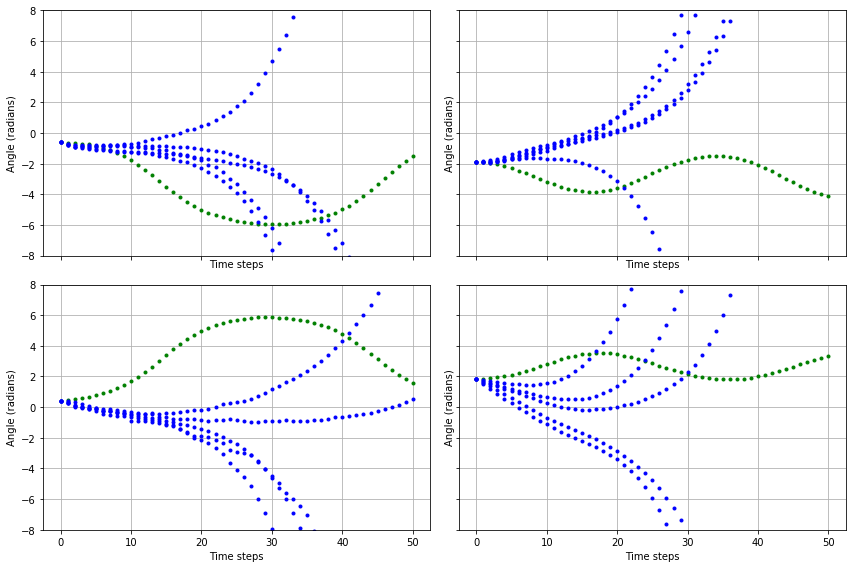

In [14]:
fig

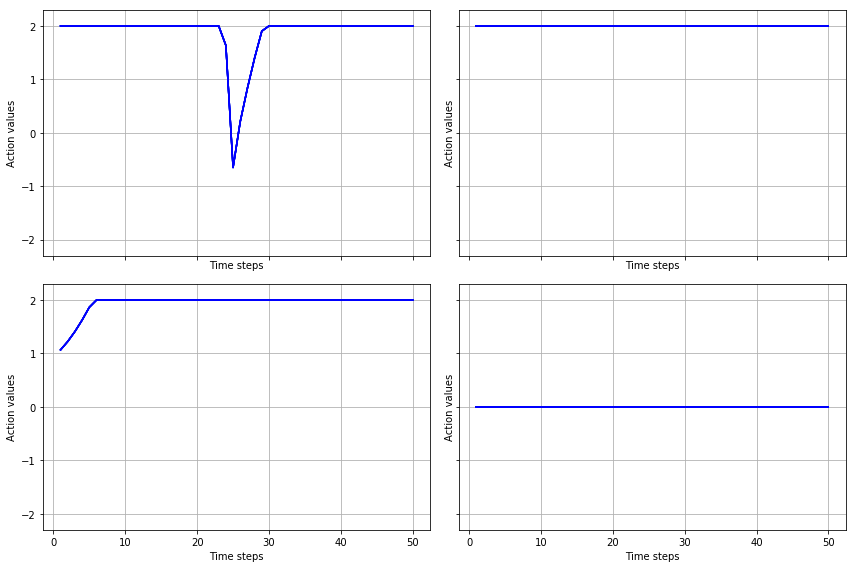

In [12]:
fig_action

In [4]:
import itertools

ps = [0.005, 0.01, 0.05, 0.1]
batch_sizes = [10, 50, 100]
epochs = [500, 1000, 2000]
# Random search of learning rate should be on log-scale
lrs = 10**np.random.uniform(low=-6, high=-1, size=10)

In [5]:
with open('./logging.txt', 'w') as f:
    f.write('Hello2\n')
    f.write('h')

In [ ]:
import time

loggings = []

for p in ps:
    list_loss = []
    hyper_params = []
    for batch_size, epoch, lr in itertools.product(batch_sizes, epochs, lrs):
        print('Settings: ', batch_size, epoch, lr)
        dynamics = DynamicsModel(env, hidden_size=300, drop_prob=p)
        
        start_time = time.time()
        
        list_batch_loss = train_dynamics_model(dynamics, optim.Adam(dynamics.parameters(), lr=lr), data_dict['10'], epochs=epoch, batch_size=batch_size)
        
        print('Time for training: {:.2f} s. '.format(time.time() - start_time))
        
        list_loss.append(list_batch_loss.min())
        hyper_params.append([batch_size, epoch, lr])
        
    list_loss = np.array(list_loss)    
    loggings.append('\n###\n# Min loss for p={:.2f} is {:.5f}, and best params:'.format(p, list_loss.min()), hyper_params[np.argmin(list_loss)])
    
with open('./loggings.txt', 'w') as f:
    for log in loggings:
        f.write(log + '\n')

Settings:  10 500 0.000754814682011
	 [Epoch #   1 (1.1 s)] Loss: 0.13461580
	 [Epoch # 251 (0.6 s)] Loss: 0.00924811
	 [Epoch # 500 (0.6 s)] Loss: 0.00509513

Finished training dynamics model. 

Time for training: 279.53 s. 
Settings:  10 500 0.000772449133691
	 [Epoch #   1 (0.3 s)] Loss: 0.15718738
	 [Epoch # 251 (0.7 s)] Loss: 0.01059434
	 [Epoch # 500 (0.7 s)] Loss: 0.00515132

Finished training dynamics model. 

Time for training: 279.11 s. 
Settings:  10 500 0.000738896375475
	 [Epoch #   1 (0.3 s)] Loss: 0.17172907
	 [Epoch # 251 (0.6 s)] Loss: 0.00871714
	 [Epoch # 500 (0.9 s)] Loss: 0.00489773

Finished training dynamics model. 

Time for training: 312.12 s. 
Settings:  10 500 0.000810628852486
	 [Epoch #   1 (0.6 s)] Loss: 0.17897936
	 [Epoch # 251 (0.8 s)] Loss: 0.00721563
	 [Epoch # 500 (0.8 s)] Loss: 0.00493478

Finished training dynamics model. 

Time for training: 351.28 s. 
Settings:  10 500 0.0004846123358
	 [Epoch #   1 (0.4 s)] Loss: 0.13607977
	 [Epoch # 251 (0.9 s

In [13]:
np.argmin([2, 1, 0, 3])

2

In [20]:
dynamics = DynamicsModel(env, hidden_size=300, drop_prob=0.1)
list_batch_loss = train_dynamics_model(dynamics, 
                                       optim.Adam(dynamics.parameters(), lr=8.1924e-4),
                                       data_dict['10'], 
                                       epochs=2000, 
                                       batch_size=50)
list_batch_loss.min()

	 [Epoch #   1 (0.1 s)] Loss: 0.14060599
	 [Epoch # 1001 (0.1 s)] Loss: 0.00151661
	 [Epoch # 2000 (0.1 s)] Loss: 0.00088122

Finished training dynamics model. 



0.00068880739272572102

In [45]:
fig, fig_actions = plot_dynamics_uncertainty(env, zero_policy, dynamics, T=T, N_uncertainty=20, N_plots=2, ylim=[-8, 8], real_tau=False)

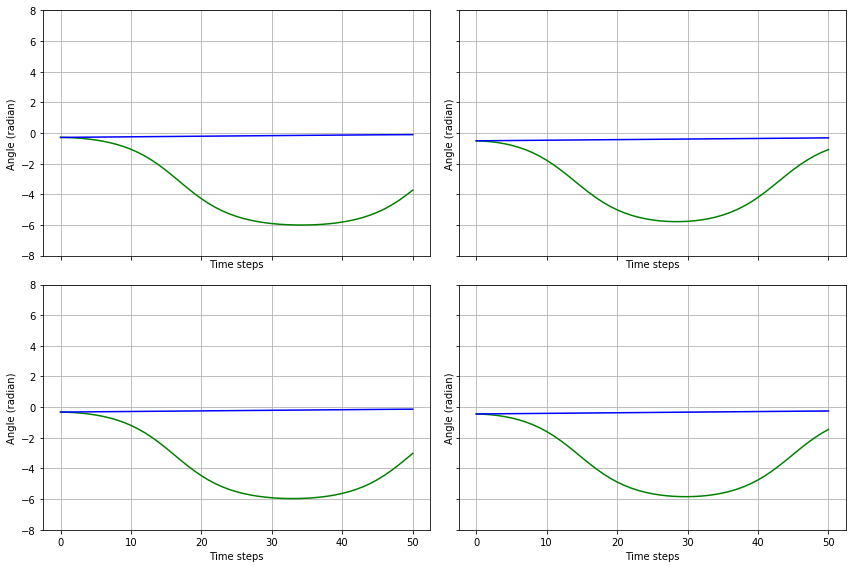

In [47]:
fig

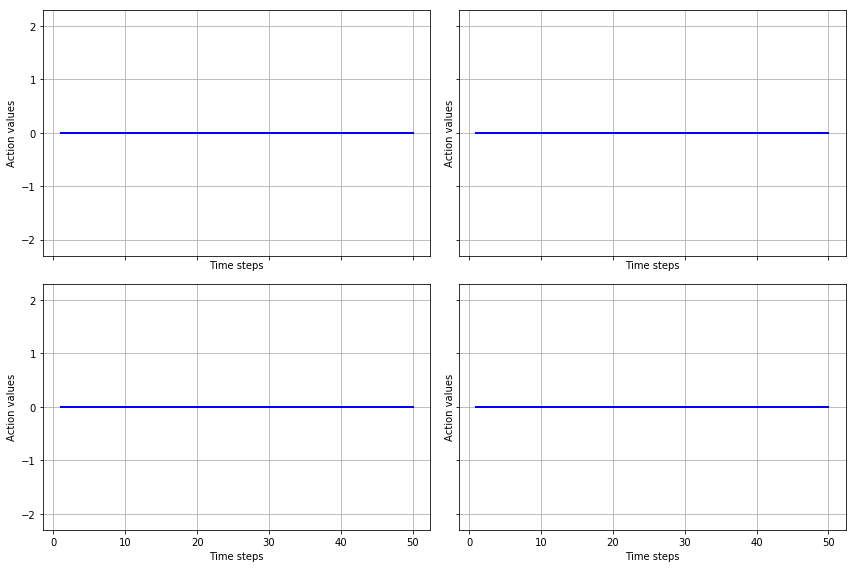

In [48]:
fig_actions

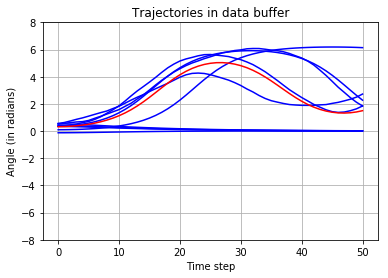

In [37]:
plot_databuffer(data_dict['10'], ylim=[-8, 8])